In [1]:
!kaggle competitions download -c playground-series-s5e2

playground-series-s5e2.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import seaborn as sns

In [3]:
test_data = pd.read_csv("test.csv")
train_data = pd.read_csv("train.csv")
sample_submission=pd.read_csv("sample_submission.csv")

In [4]:

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    300000 non-null  int64  
 1   Brand                 290295 non-null  object 
 2   Material              291653 non-null  object 
 3   Size                  293405 non-null  object 
 4   Compartments          300000 non-null  float64
 5   Laptop Compartment    292556 non-null  object 
 6   Waterproof            292950 non-null  object 
 7   Style                 292030 non-null  object 
 8   Color                 290050 non-null  object 
 9   Weight Capacity (kg)  299862 non-null  float64
 10  Price                 300000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 25.2+ MB


In [5]:
#Заменим пустые значения на "No" , 


train_data['Waterproof'] = train_data['Waterproof'].fillna("No")
train_data['Laptop Compartment'] = train_data['Laptop Compartment'].fillna("No")
train_data['Style'] = train_data['Style'].fillna("No")
train_data['Color'] = train_data['Color'].fillna("No")
train_data['Material'] = train_data['Material'].fillna("No")
train_data['Brand'] = train_data['Brand'].fillna("No")
train_data['Size'] = train_data['Size'].fillna("No")


test_data['Waterproof'] = test_data['Waterproof'].fillna("No")
test_data['Laptop Compartment'] = test_data['Laptop Compartment'].fillna("No")
test_data['Style'] = test_data['Style'].fillna("No")
test_data['Color'] = test_data['Color'].fillna("No")
test_data['Material'] = test_data['Material'].fillna("No")
test_data['Brand'] = test_data['Brand'].fillna("No")
test_data['Size'] = test_data['Size'].fillna("No")


In [6]:

test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    200000 non-null  int64  
 1   Brand                 200000 non-null  object 
 2   Material              200000 non-null  object 
 3   Size                  200000 non-null  object 
 4   Compartments          200000 non-null  float64
 5   Laptop Compartment    200000 non-null  object 
 6   Waterproof            200000 non-null  object 
 7   Style                 200000 non-null  object 
 8   Color                 200000 non-null  object 
 9   Weight Capacity (kg)  199923 non-null  float64
dtypes: float64(2), int64(1), object(7)
memory usage: 15.3+ MB


In [8]:

# ------------------------------------------------------------------------------
#  Заполнение пропущенных значений в 'Weight Capacity (kg)' (только в train_data)
mean_weight_capacity = train_data['Weight Capacity (kg)'].median()
train_data.loc[:, 'Weight Capacity (kg)'] = train_data['Weight Capacity (kg)'].fillna(mean_weight_capacity)

# Заполняем и в тестовом наборе, если столбец существует
if 'Weight Capacity (kg)' in test_data.columns:
    test_data.loc[:, 'Weight Capacity (kg)'] = test_data['Weight Capacity (kg)'].fillna(mean_weight_capacity)

# ------------------------------------------------------------------------------
# Вычисление медианных цен для разных категорий
Size_prices = train_data.groupby('Size')['Price'].median().to_dict()
train_data.loc[:, 'mean_Size_prices'] = train_data['Size'].map(Size_prices)

Waterproof_prices = train_data.groupby('Waterproof')['Price'].median().to_dict()
train_data.loc[:, 'mean_Waterproof_prices'] = train_data['Waterproof'].map(Waterproof_prices)

Laptop_Compartment_prices = train_data.groupby('Laptop Compartment')['Price'].median().to_dict()
train_data.loc[:, 'mean_Laptop_Compartment_prices'] = train_data['Laptop Compartment'].map(Laptop_Compartment_prices)

Style_prices = train_data.groupby('Style')['Price'].median().to_dict()
train_data.loc[:, 'mean_Style_prices'] = train_data['Style'].map(Style_prices)

# ------------------------------------------------------------------------------
#  Создание признаков на основе веса
train_data['Price_to_Weight'] = train_data['Price'] / train_data['Weight Capacity (kg)']

#  Вычисляем дисперсию Price_to_Weight на train_data
variance_price_to_weight_train = train_data['Price_to_Weight'].std()
train_data.loc[:, 'Price_to_Weight_variance'] = variance_price_to_weight_train

#  Создаем новый столбец в test_data и присваиваем ему дисперсию train_data
test_data['Price_to_Weight_variance'] = variance_price_to_weight_train

# ------------------------------------------------------------------------------
#  Создаем категориальный признак по весу (легкий, средний, тяжелый)
bins = [0, 10,15,20,25, float('inf')]
labels = ['VeryLight','Light', 'Medium', 'Heavy','VeryHeavy']

train_data['Weight_Category'] = pd.cut(train_data['Weight Capacity (kg)'], bins=bins, labels=labels, right=False)
test_data['Weight_Category'] = pd.cut(test_data['Weight Capacity (kg)'], bins=bins, labels=labels, right=False)

# ------------------------------------------------------------------------------
#  Группировка по 'Size' и вычисление среднего значения 'Price_to_Weight' для каждой группы
mean_price_to_weight_by_size = train_data.groupby('Size')['Price_to_Weight'].transform('mean')

# Замена значений в столбце 'Price_to_Weight' на среднее значение для каждой группы
train_data.loc[:, 'Price_to_Weight'] = mean_price_to_weight_by_size
train_data['Price_to_all_Weight'] = train_data['Price_to_Weight'] * train_data['Weight Capacity (kg)']

# ------------------------------------------------------------------------------
#  Вычисляем среднее и стандартное отклонение цены для каждого бренда и материала на train_data
grouping_columns = ['Material', 'Brand', 'Style', 'Color', 'Waterproof', 'Laptop Compartment', 'Size', 'Weight_Category']


mean_price_by_material_brand = train_data.groupby(grouping_columns, observed=True)['Price'].mean()
std_price_by_material_brand = train_data.groupby(grouping_columns, observed=True)['Price'].std()

# ------------------------------------------------------------------------------
# Создаем DataFrame для объединения
mean_df = mean_price_by_material_brand.reset_index()
mean_df.rename(columns={'Price': 'mean_price_material_brand'}, inplace=True)

std_df = std_price_by_material_brand.reset_index()
std_df.rename(columns={'Price': 'std_price_material_brand'}, inplace=True)

# ------------------------------------------------------------------------------
# Объединяем test_data с mean_df и std_df
test_data = pd.merge(test_data, mean_df, on=grouping_columns, how='left')

# Добавляем столбцы, если их не было после merge
if 'mean_price_material_brand' not in test_data.columns:
    test_data['mean_price_material_brand'] = np.nan

test_data = pd.merge(test_data, std_df, on=grouping_columns, how='left')

if 'std_price_material_brand' not in test_data.columns:
    test_data['std_price_material_brand'] = np.nan

# ------------------------------------------------------------------------------
# Заполняем NaN значения
test_data.loc[:, 'mean_price_material_brand'] = test_data['mean_price_material_brand'].fillna(train_data['Price'].mean())
test_data.loc[:, 'std_price_material_brand'] = test_data['std_price_material_brand'].fillna(0)

# ------------------------------------------------------------------------------
# Вычисляем среднее и стандартное отклонение цены для каждого бренда, материала, стиля, и цвета на train_data
mean_price_by_material_brand = train_data.groupby(grouping_columns, observed=True)['Price'].transform('mean')
std_price_by_material_brand = train_data.groupby(grouping_columns, observed=True)['Price'].transform('std')

# Добавляем новые столбцы в DataFrame
train_data.loc[:, 'mean_price_material_brand'] = mean_price_by_material_brand
train_data.loc[:, 'std_price_material_brand'] = std_price_by_material_brand

# ------------------------------------------------------------------------------
# Вывод результатов
print("train data")
print(train_data.head())
print("Test data")
print(test_data.head())



train data
   id         Brand Material    Size  Compartments Laptop Compartment  \
0   0      Jansport  Leather  Medium           7.0                Yes   
1   1      Jansport   Canvas   Small          10.0                Yes   
2   2  Under Armour  Leather   Small           2.0                Yes   
3   3          Nike    Nylon   Small           8.0                Yes   
4   4        Adidas   Canvas  Medium           1.0                Yes   

  Waterproof      Style  Color  Weight Capacity (kg)  ...  mean_Size_prices  \
0         No       Tote  Black             11.611723  ...          81.03244   
1        Yes  Messenger  Green             27.078537  ...          80.90638   
2         No  Messenger    Red             16.643760  ...          80.90638   
3         No  Messenger  Green             12.937220  ...          80.90638   
4        Yes  Messenger  Green             17.749338  ...          81.03244   

   mean_Waterproof_prices  mean_Laptop_Compartment_prices  mean_Style_price

In [9]:
# Преобразование столбца  к категориальному типу данных
train_data['Waterproof'] = train_data['Waterproof'].astype('category')
# Получение числовых кодов
train_data['Waterproof'] = train_data['Waterproof'].cat.codes


# Преобразование столбца  к категориальному типу данных
train_data['Laptop Compartment'] = train_data['Laptop Compartment'].astype('category')
# Получение числовых кодов
train_data['Laptop Compartment'] = train_data['Laptop Compartment'].cat.codes


# Преобразование столбца  к категориальному типу данных
train_data['Size'] = train_data['Size'].astype('category')

# Получение числовых кодов
train_data['Size'] = train_data['Size'].cat.codes


train_data.head(25)

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),...,mean_Size_prices,mean_Waterproof_prices,mean_Laptop_Compartment_prices,mean_Style_prices,Price_to_Weight,Price_to_Weight_variance,Weight_Category,Price_to_all_Weight,mean_price_material_brand,std_price_material_brand
0,0,Jansport,Leather,1,7.0,1,0,Tote,Black,11.611723,...,81.03244,80.83398,81.148275,80.759430,5.488895,4.092908,Light,63.735532,97.218928,33.165680
1,1,Jansport,Canvas,3,10.0,1,1,Messenger,Green,27.078537,...,80.90638,81.06270,81.148275,81.167710,5.503679,4.092908,VeryHeavy,149.031562,99.260242,34.609659
2,2,Under Armour,Leather,3,2.0,1,0,Messenger,Red,16.643760,...,80.90638,80.83398,81.148275,81.167710,5.503679,4.092908,Medium,91.601905,86.959627,44.667725
3,3,Nike,Nylon,3,8.0,1,0,Messenger,Green,12.937220,...,80.90638,80.83398,81.148275,81.167710,5.503679,4.092908,Light,71.202302,84.509914,35.066744
4,4,Adidas,Canvas,1,1.0,1,1,Messenger,Green,17.749338,...,81.03244,81.06270,81.148275,81.167710,5.488895,4.092908,Medium,97.424263,80.304642,36.204503
5,5,Nike,Canvas,1,10.0,0,1,No,Black,7.241812,...,81.03244,81.06270,80.748130,81.811395,5.488895,4.092908,VeryLight,39.749551,20.015530,NaN
6,6,Nike,No,0,3.0,0,0,Backpack,Green,6.828123,...,81.29029,80.83398,80.748130,80.843310,5.512304,4.092908,VeryLight,37.638686,119.636483,31.991257
7,7,Puma,Canvas,3,1.0,1,1,Backpack,Blue,21.488864,...,80.90638,81.06270,81.148275,80.843310,5.503679,4.092908,Heavy,118.267803,92.567387,33.736071
8,8,Under Armour,Polyester,1,8.0,1,0,Tote,Gray,10.207780,...,81.03244,80.83398,81.148275,80.759430,5.488895,4.092908,Light,56.029438,84.629102,43.852073
9,9,Under Armour,Nylon,1,2.0,1,1,Messenger,Pink,15.895100,...,81.03244,81.06270,81.148275,81.167710,5.488895,4.092908,Medium,87.246544,93.031646,40.381974


In [11]:


#  Использование map для присваивания median цен
train_data['mean_Style_prices'] = train_data['Style'].map(Style_prices)



train_data['Laptop_Compartment_Waterproof']=train_data['Laptop Compartment']*train_data['Waterproof']
train_data.head(25)

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),...,mean_Waterproof_prices,mean_Laptop_Compartment_prices,mean_Style_prices,Price_to_Weight,Price_to_Weight_variance,Weight_Category,Price_to_all_Weight,mean_price_material_brand,std_price_material_brand,Laptop_Compartment_Waterproof
0,0,Jansport,Leather,1,7.0,1,0,Tote,Black,11.611723,...,80.83398,81.148275,80.759430,5.488895,4.092908,Light,63.735532,97.218928,33.165680,0
1,1,Jansport,Canvas,3,10.0,1,1,Messenger,Green,27.078537,...,81.06270,81.148275,81.167710,5.503679,4.092908,VeryHeavy,149.031562,99.260242,34.609659,1
2,2,Under Armour,Leather,3,2.0,1,0,Messenger,Red,16.643760,...,80.83398,81.148275,81.167710,5.503679,4.092908,Medium,91.601905,86.959627,44.667725,0
3,3,Nike,Nylon,3,8.0,1,0,Messenger,Green,12.937220,...,80.83398,81.148275,81.167710,5.503679,4.092908,Light,71.202302,84.509914,35.066744,0
4,4,Adidas,Canvas,1,1.0,1,1,Messenger,Green,17.749338,...,81.06270,81.148275,81.167710,5.488895,4.092908,Medium,97.424263,80.304642,36.204503,1
5,5,Nike,Canvas,1,10.0,0,1,No,Black,7.241812,...,81.06270,80.748130,81.811395,5.488895,4.092908,VeryLight,39.749551,20.015530,NaN,0
6,6,Nike,No,0,3.0,0,0,Backpack,Green,6.828123,...,80.83398,80.748130,80.843310,5.512304,4.092908,VeryLight,37.638686,119.636483,31.991257,0
7,7,Puma,Canvas,3,1.0,1,1,Backpack,Blue,21.488864,...,81.06270,81.148275,80.843310,5.503679,4.092908,Heavy,118.267803,92.567387,33.736071,1
8,8,Under Armour,Polyester,1,8.0,1,0,Tote,Gray,10.207780,...,80.83398,81.148275,80.759430,5.488895,4.092908,Light,56.029438,84.629102,43.852073,0
9,9,Under Armour,Nylon,1,2.0,1,1,Messenger,Pink,15.895100,...,81.06270,81.148275,81.167710,5.488895,4.092908,Medium,87.246544,93.031646,40.381974,1


In [16]:
# Заполнение пропущенных значений
# Используем то же самое среднее значение, что и для train_data
test_data['Weight Capacity (kg)'] = test_data['Weight Capacity (kg)'].fillna(mean_weight_capacity)

# Присваивание медианных цен
test_data['mean_Size_prices'] = test_data['Size'].map(Size_prices)
test_data['mean_Waterproof_prices'] = test_data['Waterproof'].map(Waterproof_prices)
test_data['mean_Laptop_Compartment_prices'] = test_data['Laptop Compartment'].map(Laptop_Compartment_prices)
test_data['mean_Style_prices'] = test_data['Style'].map(Style_prices)





# Категориальное кодирование
test_data['Waterproof'] = test_data['Waterproof'].astype('category').cat.codes
test_data['Laptop Compartment'] = test_data['Laptop Compartment'].astype('category').cat.codes


# Создание новых признаков
test_data['Price_to_Weight'] = mean_price_to_weight_by_size
test_data['Price_to_all_Weight']=test_data['Price_to_Weight']*test_data['Weight Capacity (kg)']
test_data['Laptop_Compartment_Waterproof'] = test_data['Laptop Compartment'] * test_data['Waterproof']

#Категориальное кодирование
test_data['Size'] = test_data['Size'].astype('category').cat.codes

test_data.head(25)

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),...,Weight_Category,mean_price_material_brand,std_price_material_brand,mean_Size_prices,mean_Waterproof_prices,mean_Laptop_Compartment_prices,mean_Style_prices,Price_to_Weight,Price_to_all_Weight,Laptop_Compartment_Waterproof
0,300000,Puma,Leather,3,2.0,0,0,Tote,Green,20.671147,...,Heavy,86.512958,34.576004,80.90638,80.83398,80.748130,80.75943,5.488895,113.461762,0
1,300001,Nike,Canvas,1,7.0,0,1,Backpack,Green,13.564105,...,Light,90.379245,45.021186,81.03244,81.06270,80.748130,80.84331,5.503679,74.652472,0
2,300002,Adidas,Canvas,0,9.0,0,1,Messenger,Blue,11.809799,...,Light,87.894975,35.900898,81.29029,81.06270,80.748130,81.16771,5.503679,64.997338,0
3,300003,Adidas,Nylon,0,1.0,1,0,Messenger,Green,18.477036,...,Medium,95.181429,40.681797,81.29029,80.83398,81.148275,81.16771,5.503679,101.691668,0
4,300004,No,Nylon,0,2.0,1,1,Tote,Black,9.907953,...,VeryLight,45.408218,34.555445,81.29029,81.06270,81.148275,80.75943,5.488895,54.383718,1
5,300005,Under Armour,Nylon,1,8.0,0,0,Backpack,Black,17.547673,...,Medium,63.561990,36.164307,81.03244,80.83398,80.748130,80.84331,5.488895,96.317343,0
6,300006,Nike,Nylon,0,8.0,0,1,Tote,Blue,16.003025,...,Medium,88.102473,44.853879,81.29029,81.06270,80.748130,80.75943,5.512304,88.213532,0
7,300007,Jansport,Polyester,1,6.0,1,0,Backpack,Blue,24.238091,...,Heavy,101.494371,42.621945,81.03244,80.83398,81.148275,80.84331,5.503679,133.398661,0
8,300008,Nike,Canvas,0,8.0,1,1,Backpack,Red,19.181167,...,Medium,67.043153,40.497737,81.29029,81.06270,81.148275,80.84331,5.488895,105.283422,1
9,300009,Puma,Leather,0,1.0,0,0,Tote,Blue,9.937962,...,VeryLight,95.484651,24.184096,81.29029,80.83398,80.748130,80.75943,5.488895,54.548433,0


In [17]:
def one_hot_encode_columns(df, column_names, drop_first=True, sparse_output=False):
    """
    Выполняет One-Hot Encoding для нескольких указанных столбцов в DataFrame.

    Args:
        df: Исходный DataFrame.
        column_names: Список названий столбцов, которые нужно закодировать.
        drop_first: Если True, удаляет первый уровень категории (избегает мультиколлинеарности).
        sparse_output: Если True, возвращает разреженную матрицу.

    Returns:
        DataFrame с добавленными закодированными столбцами и удалёнными исходными столбцами.
        Возвращает None, если возникла ошибка.
    """
    try:
        # Проверяем, что column_names - это список
        if not isinstance(column_names, list):
            raise TypeError("column_names должен быть списком.")

        # Проходимся по каждому указанному столбцу
        for column_name in column_names:
            # Проверяем, существует ли столбец в DataFrame
            if column_name not in df.columns:
                print(f"Предупреждение: столбец '{column_name}' не найден в DataFrame. Пропускаем.")
                continue  # Переходим к следующему столбцу

            # Создаем OneHotEncoder
            encoder = OneHotEncoder(drop='first' if drop_first else None, sparse_output=sparse_output, handle_unknown='ignore')

            # Выполняем One-Hot Encoding
            encoded_features = encoder.fit_transform(df[[column_name]])

            # Преобразуем результат в DataFrame
            if sparse_output:
                encoded_df = pd.DataFrame(encoded_features.toarray(),  # Преобразуем разреженную матрицу в плотный массив
                                      index=df.index,             # Сохраняем индекс
                                      columns=encoder.get_feature_names_out([column_name]))
            else:
                encoded_df = pd.DataFrame(encoded_features,
                                           index=df.index,
                                           columns=encoder.get_feature_names_out([column_name]))


            # Объединяем закодированные признаки с исходным DataFrame
            df = pd.concat([df, encoded_df], axis=1)
            df.drop(column_name, axis=1, inplace=True) # Удаляем исходный столбец

        return df

    except Exception as e:
        print(f"Ошибка при выполнении One-Hot Encoding: {e}")
        return None

In [18]:
columns_to_encode = ['Brand', 'Material', "Style", "Color"]


encoded_train_data = one_hot_encode_columns(train_data.copy(), columns_to_encode, drop_first=True, sparse_output=False) 
encoded_test_data = one_hot_encode_columns(test_data.copy(), columns_to_encode, drop_first=True, sparse_output=False) 


In [21]:
encoded_train_data.head()
encoded_train_data['Weight Capacity (kg)']=encoded_train_data['Weight Capacity (kg)'].fillna(0)
encoded_test_data['Weight Capacity (kg)']=encoded_test_data['Weight Capacity (kg)'].fillna(0)

In [25]:
# Создаем еще новые признаки для train

#  Создание списка столбцов с "Material_"
material_columns = ['Material_Leather', 'Material_No', 'Material_Nylon', 'Material_Polyester'] #[col for col in encoded_test_data.columns if 'Material_' in col]
brand_columns=['Brand_Jansport', 'Brand_Nike', 'Brand_No', 'Brand_Puma', 'Brand_Under Armour'] #[col for col in encoded_test_data.columns if 'Brand_' in col]

for material in material_columns:
    for brand in brand_columns:
        new_column_name = f'{brand}_{material}'
        encoded_train_data[new_column_name] = encoded_train_data[brand] * encoded_train_data[material]

for material in material_columns:
    for brand in brand_columns:
        new_column_name = f'{brand}_{material}'
        encoded_test_data[new_column_name] = encoded_test_data[brand] * encoded_test_data[material]


print(brand_columns)
#encoded_train_data.head(25)

['Brand_Jansport', 'Brand_Nike', 'Brand_No', 'Brand_Puma', 'Brand_Under Armour']


In [26]:


# Перебираем признаки
encoded_train_data1=encoded_train_data[['Price','Weight Capacity (kg)','Laptop_Compartment_Waterproof','Compartments',
                                       'std_price_material_brand','Size','Price_to_all_Weight','Weight_Category','mean_price_material_brand']]
#mean_Size_prices	mean_Waterproof_prices	mean_Laptop_Compartment_prices	mean_Style_prices	

encoded_test_data1=encoded_test_data[['Weight Capacity (kg)','Laptop_Compartment_Waterproof','Compartments',
                                       'std_price_material_brand','Size','Price_to_all_Weight','Weight_Category','mean_price_material_brand']]

print(encoded_train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 56 columns):
 #   Column                                 Non-Null Count   Dtype   
---  ------                                 --------------   -----   
 0   id                                     300000 non-null  int64   
 1   Size                                   300000 non-null  int8    
 2   Compartments                           300000 non-null  float64 
 3   Laptop Compartment                     300000 non-null  int8    
 4   Waterproof                             300000 non-null  int8    
 5   Weight Capacity (kg)                   300000 non-null  float64 
 6   Price                                  300000 non-null  float64 
 7   mean_Size_prices                       300000 non-null  float64 
 8   mean_Waterproof_prices                 300000 non-null  float64 
 9   mean_Laptop_Compartment_prices         300000 non-null  float64 
 10  mean_Style_prices                      30000

['Brand_Jansport_Material_Leather', 'Brand_Nike_Material_Leather', 'Brand_No_Material_Leather', 'Brand_Puma_Material_Leather', 'Brand_Under Armour_Material_Leather', 'Brand_Jansport_Material_No', 'Brand_Nike_Material_No', 'Brand_No_Material_No', 'Brand_Puma_Material_No', 'Brand_Under Armour_Material_No', 'Brand_Jansport_Material_Nylon', 'Brand_Nike_Material_Nylon', 'Brand_No_Material_Nylon', 'Brand_Puma_Material_Nylon', 'Brand_Under Armour_Material_Nylon', 'Brand_Jansport_Material_Polyester', 'Brand_Nike_Material_Polyester', 'Brand_No_Material_Polyester', 'Brand_Puma_Material_Polyester', 'Brand_Under Armour_Material_Polyester']


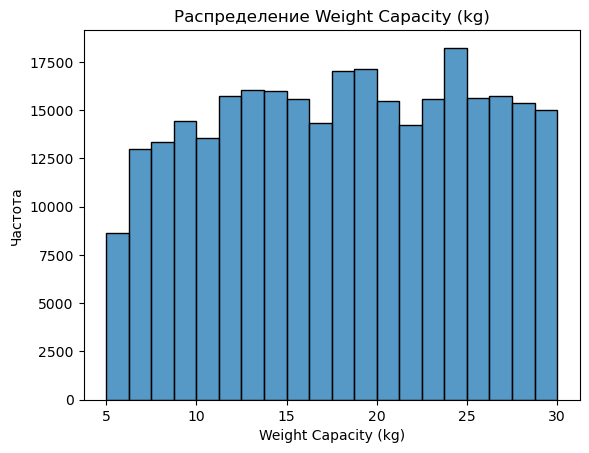

In [29]:

matching_columns = [col for col in encoded_train_data.columns if "Brand" in col and "Material" in col]
print(matching_columns)

sns.histplot(train_data['Weight Capacity (kg)'], bins=20, kde=False)  # kde=False отключает линию плотности
plt.xlabel('Weight Capacity (kg)')
plt.ylabel('Частота')
plt.title('Распределение Weight Capacity (kg)')
plt.show()

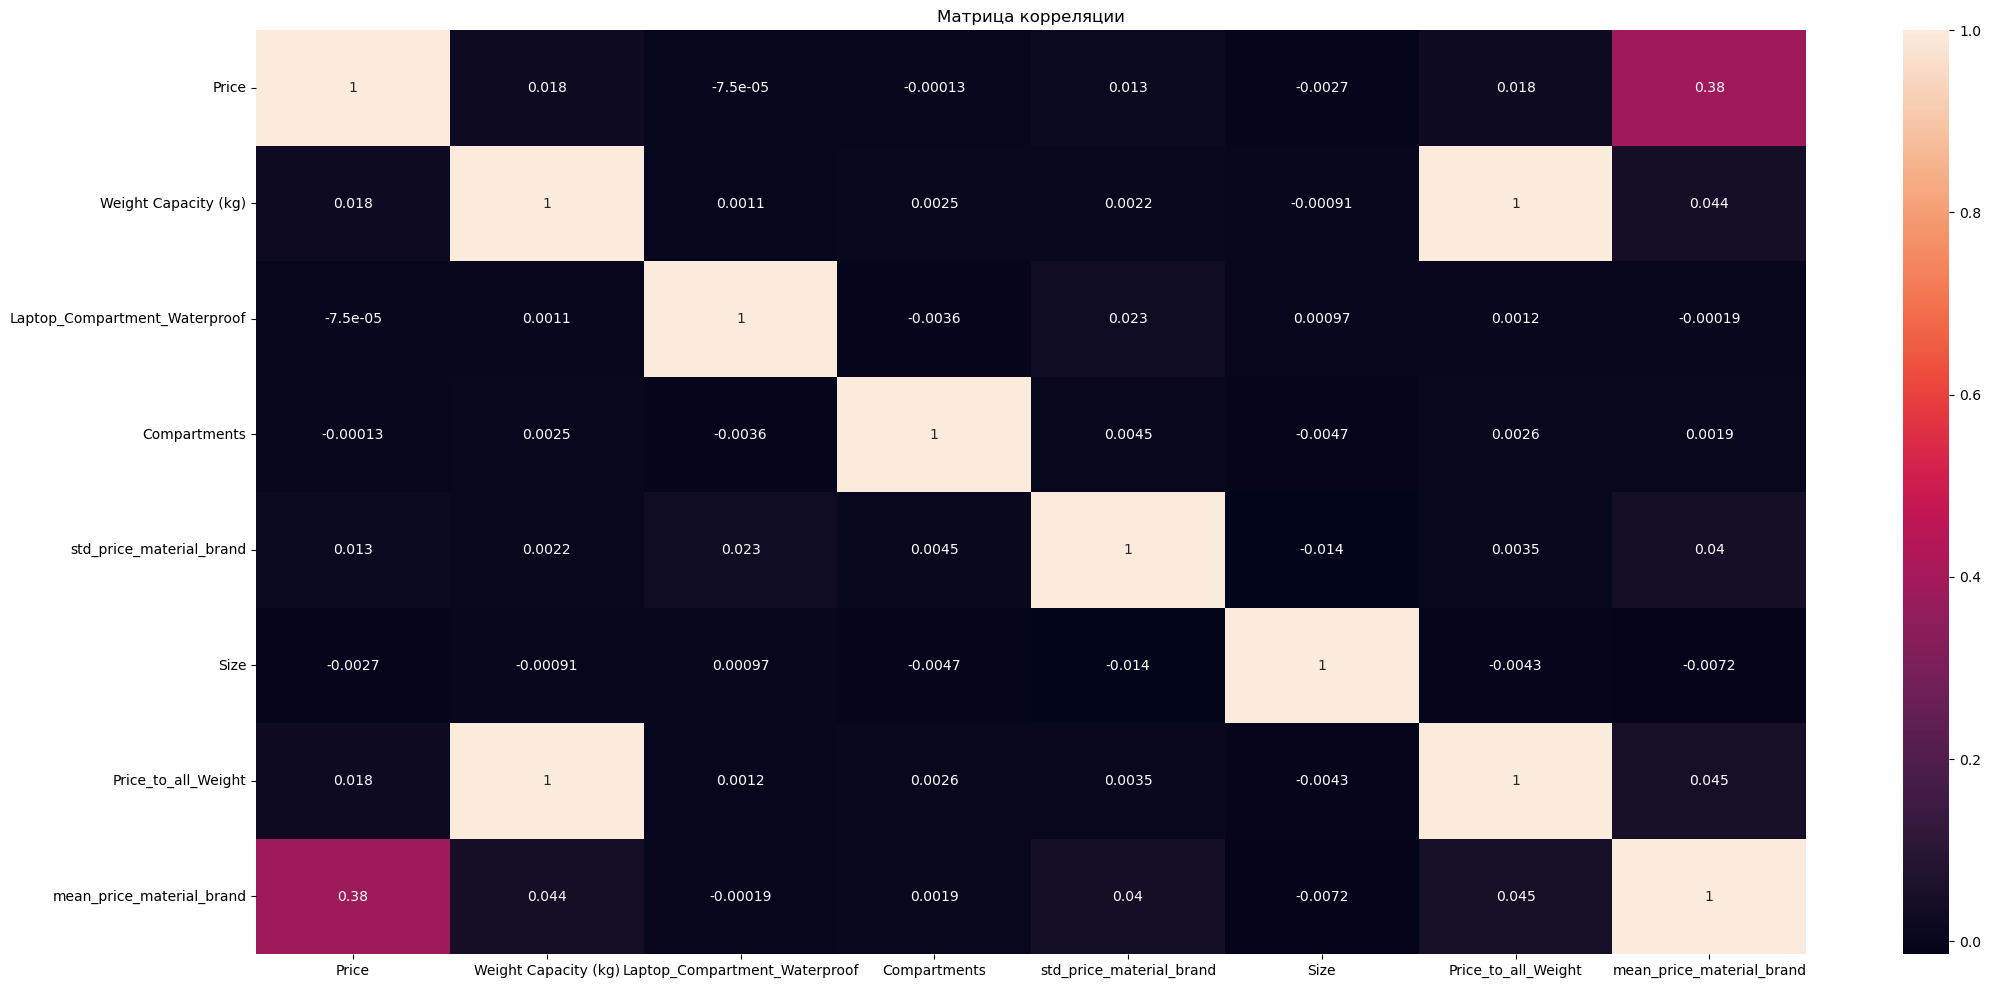

In [32]:
train_cor=encoded_train_data1.drop('Weight_Category',axis=1)
# Вычисление матрицы корреляции
cor = train_cor.corr()

# Визуализация матрицы корреляции
plt.figure(figsize=(25, 12))
sns.heatmap(cor, annot=True, annot_kws={"size": 10})
plt.title("Матрица корреляции")
plt.show()



In [34]:
y = encoded_train_data1["Price"]
X=encoded_train_data1.drop("Price",axis=1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

train_pool = Pool(data=X_train, label=y_train,cat_features=['Weight_Category'])
val_pool = Pool(data=X_val, label=y_val,cat_features=['Weight_Category'])

In [35]:
# Инициализация модели
model = CatBoostRegressor(n_estimators=2500, depth=4, learning_rate=0.01, l2_leaf_reg=1, max_bin=255, early_stopping_rounds=150, verbose=100, random_seed=52)

# Обучение модели на обучающей выборке
model.fit(train_pool, eval_set=val_pool)

# Оценка производительности модели на валидационной выборке
predictions = model.predict(val_pool)
mse = mean_squared_error(y_val, predictions)
print("Mean squared error on validation set:", mse)
rmse = np.sqrt(mse)
print("Root mean squared error on validation set:", rmse)




0:	learn: 39.0136706	test: 38.8960011	best: 38.8960011 (0)	total: 242ms	remaining: 10m 4s
100:	learn: 36.6414306	test: 36.5682930	best: 36.5682930 (100)	total: 8s	remaining: 3m 10s
200:	learn: 36.1941661	test: 36.1366903	best: 36.1366903 (200)	total: 15s	remaining: 2m 51s
300:	learn: 36.1061181	test: 36.0541060	best: 36.0541060 (300)	total: 21.2s	remaining: 2m 34s
400:	learn: 36.0855955	test: 36.0357575	best: 36.0357575 (400)	total: 27.8s	remaining: 2m 25s
500:	learn: 36.0784130	test: 36.0309139	best: 36.0309139 (500)	total: 33.4s	remaining: 2m 13s
600:	learn: 36.0748614	test: 36.0290871	best: 36.0290845 (599)	total: 38.7s	remaining: 2m 2s
700:	learn: 36.0723851	test: 36.0284566	best: 36.0283885 (691)	total: 44.6s	remaining: 1m 54s
800:	learn: 36.0702534	test: 36.0279231	best: 36.0278387 (789)	total: 49.9s	remaining: 1m 45s
900:	learn: 36.0683729	test: 36.0275855	best: 36.0275740 (890)	total: 55.2s	remaining: 1m 37s
1000:	learn: 36.0665695	test: 36.0272315	best: 36.0272315 (1000)	total

In [39]:

test_pool = Pool(data=encoded_test_data1,cat_features=['Weight_Category'])

In [41]:

# Оценка производительности модели на валидационной выборке
predictions = model.predict(test_pool)

output = pd.DataFrame({'id': test_data.id, 'Price': predictions})
output.to_csv('submission.csv', index=False)

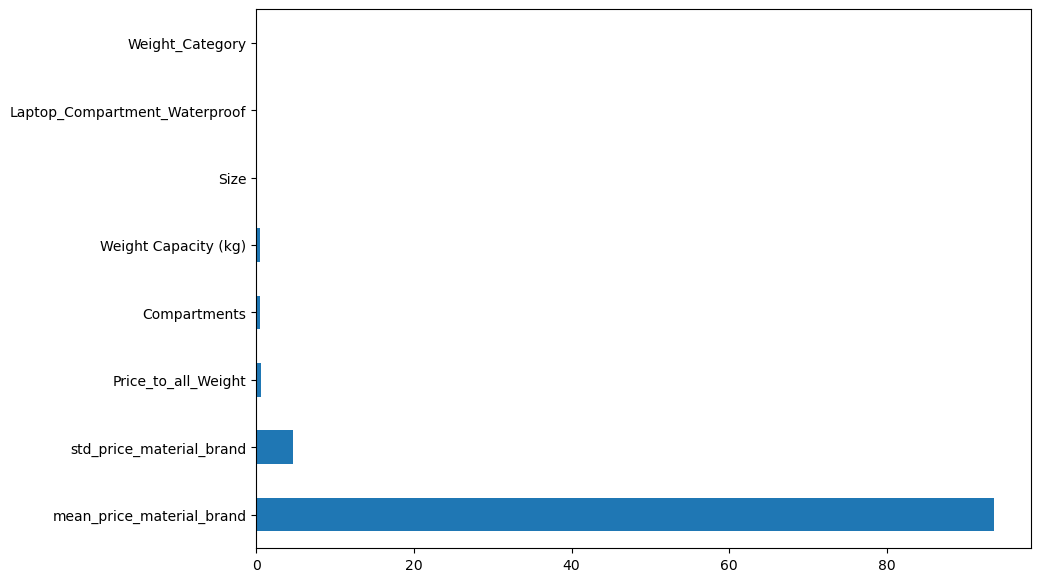

In [43]:
#  Визуализация важности признаков
plt.figure(figsize=(10, 7)) 
feat_importances = pd.Series(model.get_feature_importance(train_pool), index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh') 
plt.show()